# Airbnb - Reviews & Price NLP

## Overview

I have been contracted by a boutique real estate firm out of Manhattan Beach California to help them optimize the Airbnb branch of their business. With hundreds of properties across Los Angeles, this firm wants to ensure that they are maximizing return on each of their properties by setting an optimal per night price point. With detailed information  numerous written reviews for each of their properties, they wish to uncover whether these written reviews along with other  can be used to set optimal price points.

## Business Understanding

To perform this analysis, I have chosen to use Natural Language Processing (NLP) to build a classification model to explore whether Airbnb written reviews are reliable predictors for the ‘price per night’ of a given Airbnb listing. Specifically, for one bedroom listings as they occupy the majority of Airbnb listings in the greater Los Angeles. Based on the results, this analysis will aim to communicate clear recommendations on how to utilize this model to optimize Airbnb price listing strategy.

## The Data

The data for this analysis was pulled from [Inside Airbnb](http://insideairbnb.com/get-the-data/). The two data sets used include detailed information such as 'price', 'number of bedrooms', 'neighborhoods' from 44,000 Airbnb listings in greater Los Angeles as well as their corresponding written reviews. In the "Data Preprocessing" section below we will merge these two data sets and filter them down to the features on interest.

## Modeling

In [109]:
df_processed = pd.read_csv('../data/processed_2.csv')
df_processed

,Unnamed: 0,id,price,bedrooms,neighbourhood_cleansed,minimum_nights,maximum_nights,property_type,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,listing_id,comments,processed_reviews,price_range
0,2,15239926,201,1.0,Santa Clarita,2,30,Other,1,4.99,4.98,5.00,4.99,5.00,4.97,4.86,1.523993e+07,Fantastic super hosts and space . What a beaut...,fantastic super host space beautiful place sta...,3
1,3,14821183,88,1.0,Diamond Bar,1,1125,Private Room,1,3.00,4.00,2.00,5.00,5.00,4.00,3.00,1.482118e+07,Quiet house. Bedroom is enough for sleeping. u...,quiet house bedroom enough sleep unclean,0
2,6,26296415,180,1.0,Torrance,1,1125,Entire Unit,1,5.00,5.00,5.00,5.00,5.00,5.00,5.00,2.629642e+07,Amazing experience. The house was also recentl...,amaze experience house also recently upgrade w...,2
3,7,22746714,35,1.0,North El Monte,1,1125,Private Room,1,4.57,5.00,4.57,4.71,4.43,4.43,4.71,2.274671e+07,Nice neighborhood and hosts. Great location. T...,nice neighborhood host great location host res...,0
4,19,52992116,200,1.0,Silver Lake,2,30,Guest Suite,1,5.00,5.00,5.00,4.97,5.00,5.00,5.00,5.299212e+07,Everything was great! The room was nice and cl...,everything great room nice clean describe chec...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,593563874468145823,50,1.0,South El Monte,5,365,Private Room,1.5,4.86,4.86,5.00,5.00,4.57,4.57,4.86,5.935639e+17,"Great place, good communication and excellent ...",great place good communication excellent servi...,0
5267,13856,16134682,186,1.0,West Hollywood,2,10,Entire Unit,1,5.00,5.00,5.00,5.00,5.00,5.00,5.00,1.613468e+07,Bella’s place is everything you see on the pic...,bella place everything see picture good best s...,2
5268,13861,45361780,134,1.0,Hawthorne,1,26,Entire Unit,1,4.90,4.89,4.75,4.91,4.95,4.73,4.74,4.536178e+07,The place was exactly how the owner described ...,place exactly owner describe beautiful locatio...,1
5269,13864,924091269757225413,120,1.0,Beverly Hills,1,28,Entire Unit,1,1.00,1.00,1.00,1.00,1.00,5.00,1.00,9.240913e+17,"Since they sent me a review, I guess I’m revie...",since send review guess review confirm reserva...,1


In [110]:
#checking for nulls
df_processed.isna().sum()

Unnamed: 0                     0
id                             0
price                          0
bedrooms                       0
neighbourhood_cleansed         0
minimum_nights                 0
maximum_nights                 0
property_type                  0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
listing_id                     0
comments                       0
processed_reviews              3
price_range                    0
dtype: int64

In [111]:
#dropping nulls
df_processed.dropna(inplace=True)
df_processed.isna().sum()

Unnamed: 0                     0
id                             0
price                          0
bedrooms                       0
neighbourhood_cleansed         0
minimum_nights                 0
maximum_nights                 0
property_type                  0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
listing_id                     0
comments                       0
processed_reviews              0
price_range                    0
dtype: int64

### SIMPLE MODEL (NLP Only)

Train test split with 'price' as a discrete targetUsing ColumnTransformer

In [6]:
#train test split 
X = df_processed["processed_reviews"]
y = df_processed["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#sanity check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3964,), (1322,), (3964,), (1322,))

### Linear Regression - Not Relevant!

In [64]:
# #instantiate simple model 
# pipe_lr = Pipeline([("vec", CountVectorizer()), ("lreg", LinearRegression())])

In [67]:
# from sklearn.model_selection import cross_validate

In [68]:
# scores = cross_validate(pipe_lr, X_train, y_train, cv=3, 
#                         scoring=('r2', 'neg_mean_squared_error'), 
#                         return_train_score=True)

In [71]:
# scores

{'fit_time': array([878.05117702, 591.76208997, 739.64259696]),
 'score_time': array([2.25494194, 1.80523682, 2.06091213]),
 'test_r2': array([ -178.56458962, -2651.70339649, -5278.74265526]),
 'train_r2': array([0.99903127, 0.99930777, 0.99951327]),
 'test_neg_mean_squared_error': array([-7.30324878e+08, -9.05486962e+09, -7.63545058e+08]),
 'train_neg_mean_squared_error': array([-1723.67717788, -1457.95388423, -1820.54631292])}

### Baseline Model (NLP Only)

In [7]:
#instantiate pipeline for basic Logistic Regression
pipe_logr_base = Pipeline([("vec", CountVectorizer()), ("lreg", LogisticRegression(max_iter=10000))])

In [8]:
#cross-validate & return scores
scores = cross_validate(pipe_logr_base, X_train, y_train, 
                        cv=5, return_train_score=True, verbose=3, n_jobs=-2)
scores

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

### Logistic Regression - GridSearch (NLP Only)

In [100]:
pipe_logr = Pipeline([("vec", TfidfVectorizer()), ("lreg", LogisticRegression())])

In [102]:
#Grid search for hyperparameter tuning the Logistic Regression

#Define parameter grid for the vectorizer and logistic regression
log_param_grid = {
    'vec__min_df': [.01, .02, .03],
    'vec__max_df': [.88, .90, .92],
    'vec__ngram_range': [(1,1), (1,2), (1,3)],
    'lreg__penalty': [None, 'l2', 'l1'],
    'lreg__class_weight': [None, 'balanced'],
    'lreg__solver': ['lbfgs', 'liblinear'],
    'lreg__max_iter': [1000, 10000]
}


log_grid = GridSearchCV(pipe_logr, log_param_grid, cv=5, n_jobs=-2, verbose=1, scoring='accuracy')
log_grid.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 420, i

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('lreg', LogisticRegression())]),
             n_jobs=-2,
             param_grid={'lreg__class_weight': [None, 'balanced'],
                         'lreg__max_iter': [1000, 10000],
                         'lreg__penalty': [None, 'l2', 'l1'],
                         'lreg__solver': ['lbfgs', 'liblinear'],
                         'vec__max_df': [0.88, 0.9, 0.92],
                         'vec__min_df': [0.01, 0.02, 0.03],
                         'vec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=1)

In [106]:
log_grid.best_params_

{'lreg__class_weight': None,
 'lreg__max_iter': 1000,
 'lreg__penalty': 'l2',
 'lreg__solver': 'lbfgs',
 'vec__max_df': 0.9,
 'vec__min_df': 0.03,
 'vec__ngram_range': (1, 3)}

In [105]:
log_grid.best_score_

0.45990534144692363

**5% improvement in tuned logistic regression model with Tf-Idf vectorizer**

### Decision Tree Classifier - NLP only

In [113]:
pipe_dt = Pipeline([("vec", TfidfVectorizer()), ("dt", DecisionTreeClassifier(random_state=42))])

In [114]:
#set up parameter grid
grid_dt = {'dt__max_depth': ['None', 2, 5, 10],
       'dt__min_samples_split': [2, 5],
       'vec__ngram_range': [(1,1), (1,2)],
        'vec__max_df': [.8, .9, .99],
        'vec__min_df': [.01, .05]}
#instantiate Grid Search for decision tree and vectorizer
gs = GridSearchCV(estimator=pipe_dt, param_grid=grid_dt, verbose=2)

#fit it to training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.7s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.6s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.5s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.5s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.7s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  14.1s
[CV] EN

[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.6s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.5s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.4s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.6s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8

[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   6.0s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   5.9s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.5s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.1s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.4s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec_

[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.2s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  16.8s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  16.7s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  16.8s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   5.8s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   5.8s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   5.8s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec_

[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  19.3s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.6s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.9s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.0s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.6s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.6s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec_

[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.4s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.4s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.4s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.9s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.0s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec_

[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  21.9s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  20.9s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  21.1s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  21.6s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  20.9s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.4s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.2s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.9, vec__min_df=0.

[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  21.6s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  20.4s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.0s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.0s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.0s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   8.9s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.1s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 420, in 

GridSearchCV(estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__max_depth': ['None', 2, 5, 10],
                         'dt__min_samples_split': [2, 5],
                         'vec__max_df': [0.8, 0.9, 0.99],
                         'vec__min_df': [0.01, 0.05],
                         'vec__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

## Modeling - ```Reviews``` & Other Features

In [186]:
df_processed_out = pd.read_csv('../data/processed_2.csv')
df_processed_out

,Unnamed: 0,id,price,bedrooms,neighbourhood_cleansed,minimum_nights,maximum_nights,property_type,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,listing_id,comments,processed_reviews,price_range
0,2,15239926,201,1.0,Santa Clarita,2,30,Other,1,4.99,4.98,5.00,4.99,5.00,4.97,4.86,1.523993e+07,Fantastic super hosts and space . What a beaut...,fantastic super host space beautiful place sta...,3
1,3,14821183,88,1.0,Diamond Bar,1,1125,Private Room,1,3.00,4.00,2.00,5.00,5.00,4.00,3.00,1.482118e+07,Quiet house. Bedroom is enough for sleeping. u...,quiet house bedroom enough sleep unclean,0
2,6,26296415,180,1.0,Torrance,1,1125,Entire Unit,1,5.00,5.00,5.00,5.00,5.00,5.00,5.00,2.629642e+07,Amazing experience. The house was also recentl...,amaze experience house also recently upgrade w...,2
3,7,22746714,35,1.0,North El Monte,1,1125,Private Room,1,4.57,5.00,4.57,4.71,4.43,4.43,4.71,2.274671e+07,Nice neighborhood and hosts. Great location. T...,nice neighborhood host great location host res...,0
4,19,52992116,200,1.0,Silver Lake,2,30,Guest Suite,1,5.00,5.00,5.00,4.97,5.00,5.00,5.00,5.299212e+07,Everything was great! The room was nice and cl...,everything great room nice clean describe chec...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,593563874468145823,50,1.0,South El Monte,5,365,Private Room,1.5,4.86,4.86,5.00,5.00,4.57,4.57,4.86,5.935639e+17,"Great place, good communication and excellent ...",great place good communication excellent servi...,0
5267,13856,16134682,186,1.0,West Hollywood,2,10,Entire Unit,1,5.00,5.00,5.00,5.00,5.00,5.00,5.00,1.613468e+07,Bella’s place is everything you see on the pic...,bella place everything see picture good best s...,2
5268,13861,45361780,134,1.0,Hawthorne,1,26,Entire Unit,1,4.90,4.89,4.75,4.91,4.95,4.73,4.74,4.536178e+07,The place was exactly how the owner described ...,place exactly owner describe beautiful locatio...,1
5269,13864,924091269757225413,120,1.0,Beverly Hills,1,28,Entire Unit,1,1.00,1.00,1.00,1.00,1.00,5.00,1.00,9.240913e+17,"Since they sent me a review, I guess I’m revie...",since send review guess review confirm reserva...,1


In [187]:
df_processed.dropna(inplace=True)
df_processed.isna().sum()

Unnamed: 0                     0
id                             0
price                          0
bedrooms                       0
neighbourhood_cleansed         0
minimum_nights                 0
maximum_nights                 0
property_type                  0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
listing_id                     0
comments                       0
processed_reviews              0
price_range                    0
dtype: int64

Exploring 'price' breakdown by looking at the inter quartile range (IQR).

In [188]:
df_processed_out['price'].describe()

count    5271.000000
mean      165.348700
std        88.156979
min        10.000000
25%       109.000000
50%       148.000000
75%       199.000000
max       895.000000
Name: price, dtype: float64

### Converting Tagret Variable ('Price') to Discrete

Using each inter quartile as a range of prices to convert the 'price' target variable to a discrete variable.

In [189]:
#create a column that sorts price based on categories of ranges of price
conditions = [
    (df_processed_out['price'] <= 109),
    (df_processed_out['price'] > 109) & (df_processed_out['price'] <= 148),
    (df_processed_out['price'] > 148) & (df_processed_out['price'] <= 199),
    (df_processed_out['price'] > 199)]

#create a list of the values we want to assign for each condition
values = [0, 1, 2, 3]

#create a new column and use np.select to assign values to it using our lists as arguments
df_processed_out['price_range'] = np.select(conditions, values)
df_processed_out

,Unnamed: 0,id,price,bedrooms,neighbourhood_cleansed,minimum_nights,maximum_nights,property_type,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,listing_id,comments,processed_reviews,price_range
0,2,15239926,201,1.0,Santa Clarita,2,30,Other,1,4.99,4.98,5.00,4.99,5.00,4.97,4.86,1.523993e+07,Fantastic super hosts and space . What a beaut...,fantastic super host space beautiful place sta...,3
1,3,14821183,88,1.0,Diamond Bar,1,1125,Private Room,1,3.00,4.00,2.00,5.00,5.00,4.00,3.00,1.482118e+07,Quiet house. Bedroom is enough for sleeping. u...,quiet house bedroom enough sleep unclean,0
2,6,26296415,180,1.0,Torrance,1,1125,Entire Unit,1,5.00,5.00,5.00,5.00,5.00,5.00,5.00,2.629642e+07,Amazing experience. The house was also recentl...,amaze experience house also recently upgrade w...,2
3,7,22746714,35,1.0,North El Monte,1,1125,Private Room,1,4.57,5.00,4.57,4.71,4.43,4.43,4.71,2.274671e+07,Nice neighborhood and hosts. Great location. T...,nice neighborhood host great location host res...,0
4,19,52992116,200,1.0,Silver Lake,2,30,Guest Suite,1,5.00,5.00,5.00,4.97,5.00,5.00,5.00,5.299212e+07,Everything was great! The room was nice and cl...,everything great room nice clean describe chec...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,593563874468145823,50,1.0,South El Monte,5,365,Private Room,1.5,4.86,4.86,5.00,5.00,4.57,4.57,4.86,5.935639e+17,"Great place, good communication and excellent ...",great place good communication excellent servi...,0
5267,13856,16134682,186,1.0,West Hollywood,2,10,Entire Unit,1,5.00,5.00,5.00,5.00,5.00,5.00,5.00,1.613468e+07,Bella’s place is everything you see on the pic...,bella place everything see picture good best s...,2
5268,13861,45361780,134,1.0,Hawthorne,1,26,Entire Unit,1,4.90,4.89,4.75,4.91,4.95,4.73,4.74,4.536178e+07,The place was exactly how the owner described ...,place exactly owner describe beautiful locatio...,1
5269,13864,924091269757225413,120,1.0,Beverly Hills,1,28,Entire Unit,1,1.00,1.00,1.00,1.00,1.00,5.00,1.00,9.240913e+17,"Since they sent me a review, I guess I’m revie...",since send review guess review confirm reserva...,1


In [190]:
df_processed_out['processed_reviews'].isna().sum()

3

In [191]:
#dropping null values
df_processed_out.dropna(subset=['processed_reviews'], inplace=True)

In [192]:
df_processed_out['price_range'].isna().sum()

0

In [193]:
df_processed_out['bathrooms_text'].value_counts()

1            4980
1.5           170
2              66
11             16
0              10
2.5             8
6               6
Half-bath       6
Private         2
3               2
Shared          1
11.5            1
Name: bathrooms_text, dtype: int64

In [198]:
#drop long term stays
b = ['11', '6', 'Half-bath', 'Private', 'Shared', '11.5']
bathroom_drop = df_processed_out[df_processed_out['bathrooms_text'].isin(b)].index
df_processed_out.drop(bathroom_drop, inplace=True)

In [199]:
df_processed_out['bathrooms_text'].value_counts()

1      4980
1.5     170
2        66
0        10
2.5       8
3         2
Name: bathrooms_text, dtype: int64

In [200]:
df_processed_out['bathrooms_text'] = df_processed_out['bathrooms_text'].astype(float)

In [201]:
#train test split on data after using new Regex pattern in pre-processing
X = df_processed_out[['processed_reviews', 'neighbourhood_cleansed', 'property_type', 'bathrooms_text', 
                      'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 
                      'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                      'review_scores_value']]
y = df_processed_out["price_range"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((3927, 11), (1309, 11), (3927,), (1309,))

In [202]:
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3927 entries, 4644 to 871
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   processed_reviews            3927 non-null   object 
 1   neighbourhood_cleansed       3927 non-null   object 
 2   property_type                3927 non-null   object 
 3   bathrooms_text               3927 non-null   float64
 4   review_scores_rating         3927 non-null   float64
 5   review_scores_accuracy       3927 non-null   float64
 6   review_scores_cleanliness    3927 non-null   float64
 7   review_scores_checkin        3927 non-null   float64
 8   review_scores_communication  3927 non-null   float64
 9   review_scores_location       3927 non-null   float64
 10  review_scores_value          3927 non-null   float64
dtypes: float64(8), object(3)
memory usage: 368.2+ KB


### Using ColumnTransformer

In [158]:
# X_train2_text = X_train2['processed_reviews']]
# X_train2_cat = X_train2[['neighbourhood_cleansed']]

In [203]:
# Creating column transformer for categorical and text data
text_pipeline = Pipeline(steps=[('vec', TfidfVectorizer())])

categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('text', text_pipeline, 'processed_reviews'),
    ('cat', categorical_pipeline, ['neighbourhood_cleansed'])], remainder='passthrough')

In [215]:
# Creating column transformer for categorical and text data
text_pipeline = Pipeline(steps=[('vec', TfidfVectorizer())])

categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

transformer2 = ColumnTransformer(transformers=[
    ('text', text_pipeline, 'processed_reviews'),
    ('cat', categorical_pipeline, ['neighbourhood_cleansed', 'property_type'])], remainder='passthrough')

### Logistic Regression - ***New Regex Pattern***

In [185]:
pipe_log = Pipeline([("vec", TfidfVectorizer()), ("log", LogisticRegression(max_iter=10000))])

pipe_log_score = np.mean(cross_val_score(pipe_log, X_train2, y_train2, cv=5, scoring="accuracy", verbose=2))

print(f"Simple Logistic Regression Cross Validation Accuracy Score: {pipe_log_score*100:,.2f}%")

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1207, in fit
    X, y = self._validate_data(
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py", line 1165, in check_X_y
    check_consistent_length(X, y)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py", line 409, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [3, 3171]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1207, in fit
    X, y = self._validate_data(
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py", line 1165, in check_X_y
    check_consistent_length(X, y)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py", line 409, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [3, 3172]


**Using column transformer**

In [207]:
pipe_log = Pipeline([("col_tr", transformer), ("log", LogisticRegression(multi_class= 'multinomial', max_iter=10000))])

pipe_log_score = np.mean(cross_val_score(pipe_log, X_train2, y_train2, cv=5, scoring="accuracy", verbose=2))

print(f"Simple Logistic Regression Cross Validation Accuracy Score: {pipe_log_score*100:,.2f}%")

[CV] END .................................................... total time=   3.5s
[CV] END .................................................... total time=   3.5s
[CV] END .................................................... total time=   3.3s
[CV] END .................................................... total time=   3.4s
[CV] END .................................................... total time=   3.5s


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py", line 846, in _hstack
    converted_Xs = [
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py", line 847, in <listcomp>
    check_array(X, accept_sparse=True, force_all_finite=False)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py", line 917, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/core/_asarray.py", line 85, in asarray
    return array(a, dtype, copy=False, order=order)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py", line 1781, in __array__
    return np.asarray(self._values, dtype=dtype)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/core/_asarray.py", line 85, in asarray
    return array(a, dtype, copy=False, order=order)
ValueError: could not convert string to float: 'Entire Unit'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 370, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 950, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py", line 767, in fit_transform
    return self._hstack(list(Xs))
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py", line 851, in _hstack
    raise ValueError(
ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py", line 846, in _hstack
    converted_Xs = [
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py", line 847, in <listcomp>
    check_array(X, accept_sparse=True, force_all_finite=False)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py", line 917, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/core/_asarray.py", line 85, in asarray
    return array(a, dtype, copy=False, order=order)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py", line 1781, in __array__
    return np.asarray(self._values, dtype=dtype)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/core/_asarray.py", line 85, in asarray
    return array(a, dtype, copy=False, order=order)
ValueError: could not convert string to float: 'Private Room'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 370, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 950, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py", line 767, in fit_transform
    return self._hstack(list(Xs))
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py", line 851, in _hstack
    raise ValueError(
ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.


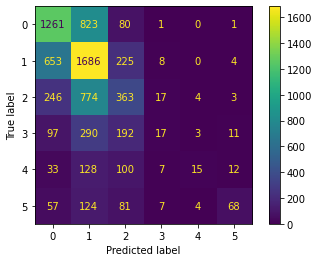

In [48]:
#plot confusion matrix
y_pred_log_cv = cross_val_predict(pipe_log, X_train2, y_train2, cv=5)

log_matrix = confusion_matrix(y_train2, y_pred_log_cv)
ConfusionMatrixDisplay(log_matrix).plot();

### Using more features and column transformer

In [212]:
X_train2['bathrooms_text'].value_counts()

1.0    3743
1.5     124
2.0      45
0.0       9
2.5       5
3.0       1
Name: bathrooms_text, dtype: int64

In [216]:
pipe_log = Pipeline([("col_tr", transformer2), ("log", LogisticRegression(multi_class= 'multinomial', max_iter=10000))])

pipe_log_score = np.mean(cross_val_score(pipe_log, X_train2, y_train2, cv=5, scoring="accuracy", verbose=2))

print(f"Simple Logistic Regression Cross Validation Accuracy Score: {pipe_log_score*100:,.2f}%")

[CV] END .................................................... total time=  58.6s
[CV] END .................................................... total time=  42.7s
[CV] END .................................................... total time=  47.7s
[CV] END .................................................... total time=  47.6s
[CV] END .................................................... total time=  55.3s
Simple Logistic Regression Cross Validation Accuracy Score: 55.05%


In [222]:
pipe_log = Pipeline([("col_tr", transformer2), ("log", LogisticRegression(multi_class= 'multinomial', max_iter=10000))])

pipe_log_scores = cross_validate(pipe_log, X_train2, y_train2, cv=5, return_train_score=True, verbose=2)
pipe_log_scores

[CV] END .................................................... total time=  52.1s
[CV] END .................................................... total time=  39.0s
[CV] END .................................................... total time=  45.1s
[CV] END .................................................... total time=  36.9s
[CV] END .................................................... total time=  48.0s


{'fit_time': array([51.29345202, 38.10963511, 44.23032975, 36.05444503, 47.20090699]),
 'score_time': array([0.82299709, 0.92542505, 0.9160111 , 0.8186748 , 0.82153606]),
 'test_score': array([0.54707379, 0.5610687 , 0.53630573, 0.54522293, 0.56305732]),
 'train_score': array([0.83858644, 0.8283986 , 0.83481859, 0.82622533, 0.83131763])}

In [39]:
#Grid search for hyperparameter tuning the Logistic Regression

#Define parameter grid for the vectorizer and Logistic regression
log_param_grid = {
    'vec__ngram_range': [(1, 1), (1, 2)],
    'vec__min_df': [0.05, 0.1, 0.15, 0.2],
    'vec__max_df': [0.9, 0.95, 1.0],
    'log__penalty': [None, 'l2', 'l1'],
    'log__class_weight': [None, 'balanced'],
    'log__solver': ['lbfgs', 'liblinear'],
    'log__max_iter': [1000, 10000]
}


log_grid = GridSearchCV(pipe_log, log_param_grid, cv=5, verbose=2, scoring='accuracy')
log_grid.fit(X_train2, y_train2)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  18.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  23.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  23.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  24.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.0s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  12.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  12.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  12.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  16.0s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  12.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   7.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  18.0s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  17.7s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  17.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  17.8s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   7.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   7.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  19.0s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_r

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_r

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  16.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  16.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_ran

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  14.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  12.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  12.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  14.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  14.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  16.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  16.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  16.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_ra

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   5.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   5.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  15.8s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  16.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  15.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_r

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  15.7s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_r

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.9min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 3.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.0min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.9min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.6min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  58.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  46.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.2min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.5min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  20.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  18.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  20.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  19.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1)

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.9min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 3.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_r

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 6.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 5.9min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.4min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.7min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.5min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_ra

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.7min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  28.6s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  26.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  29.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  27.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 4.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 4.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 4.6min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.5min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 4.3min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.6min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.7min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 3.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 4.0min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 3.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 3.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 6.0min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 6.0min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 6.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 6.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 5.9min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.4min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.7min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.5min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.7min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  28.8s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  26.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  29.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  27.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1)

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.4s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  10.8s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  11.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  10.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  25.8s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  26.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  10.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  10.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  10.4s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  10.3s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  24.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2);

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   7.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   7.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   7.4s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec_

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.4s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngr

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.6s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2);

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.3s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, 

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   5.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   5.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  20.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  23.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  42.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  18.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  36.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  18.0s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  14.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  32.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  29.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  29.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  26.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  23.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  41.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  18.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  18.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  16.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  14.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  16.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  14.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  31.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  31.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  29.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  31.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  26.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  18.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  37.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  36.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  16.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.7s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  13.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  31.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  31.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  32.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9,

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  13.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  13.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__ma

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.8s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.0s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0,

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  19.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   7.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   7.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   7.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   7.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_ra

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  18.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  18.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  18.8s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.8s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngra

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.4s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_ra

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, 

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.4s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.4s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_d

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.8s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_rang

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  12.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ng

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, 

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  16.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.0s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.0s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.6min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.6min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 4.5min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.0min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.6min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.8min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 1.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  43.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  30.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  53.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  44.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.2min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  14.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2,

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 4.5min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.1min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.5min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.8min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__m

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 1.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.2min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  45.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  31.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  52.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  44.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__mi

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  14.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.4s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_d

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 4.6min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.1min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.6min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.9min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.9min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 1.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  43.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  30.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  53.8s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  44.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.5min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 2.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  18.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  23.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  27.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  22.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2,

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  21.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  19.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  19.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  19.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.4s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  19.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  20.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  34.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  13.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  13.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  13.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  31.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  31.4s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  29.8s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  11.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  12.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  25.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  25.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  24.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  24.8s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  24.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ng

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   8.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   8.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   8.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  22.4s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  22.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.8s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, 

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  14.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   5.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngr

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__n

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   5.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__n

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  16.4s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec_

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  16.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  16.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.8s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, 

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
960 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 420, in

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('log',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'log__class_weight': [None, 'balanced'],
                         'log__max_iter': [1000, 10000],
                         'log__penalty': [None, 'l2', 'l1'],
                         'log__solver': ['lbfgs', 'liblinear'],
                         'vec__max_df': [0.9, 0.95, 1.0],
                         'vec__min_df': [0.05, 0.1, 0.15, 0.2],
                         'vec__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=2)

In [40]:
log_grid.best_params_

{'log__class_weight': None,
 'log__max_iter': 1000,
 'log__penalty': 'l2',
 'log__solver': 'lbfgs',
 'vec__max_df': 0.9,
 'vec__min_df': 0.05,
 'vec__ngram_range': (1, 2)}

In [41]:
log_grid.best_score_

0.45300878972278563

**The baseline Logistic Regression model performed better than the tuned Logistic Regression model above.**
   
   1. Untuned: accuracy = 46.11%
   2. Tuned: accuracy = 45.30%

### Decision Tree - ***New Regex Pattern***

In [183]:
pipe_dt = Pipeline([("col_tr", transformer), ("dt", DecisionTreeClassifier(random_state=42))])

pipe_dt_score = np.mean(cross_val_score(pipe_dt, X_train2, y_train2, cv=5, scoring="accuracy"))

print(f"Random Forest Cross Validation Accuracy Score: {pipe_dt_score*100:,.2f}%")

Random Forest Cross Validation Accuracy Score: 38.90%


### Column Transformer

In [ ]:
# Creating column transformer for categorical and text data
text_pipeline = Pipeline(steps=[('vec', TfidfVectorizer())])

categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('text', text_pipeline, 'processed_reviews'),
    ('cat', categorical_pipeline, ['neighbourhood_cleansed'])], remainder='passthrough')

### Random Forest - ***New Regex Pattern***

Simple Random Forest Model without gridsearching hyperparameters

In [24]:
pipe_rf = Pipeline([("vec", TfidfVectorizer()), ("rf", RandomForestClassifier(random_state=42))])

pipe_rf_score = np.mean(cross_val_score(pipe_rf, X_train2, y_train2, cv=5, scoring="accuracy"))

print(f"Random Forest Cross Validation Accuracy Score: {pipe_rf_score*100:,.2f}%")

Random Forest Cross Validation Accuracy Score: 39.12%


In [186]:
pipe_rf = Pipeline([("col_tr", transformer), ("rf", RandomForestClassifier(random_state=42))])

pipe_rf_score = np.mean(cross_val_score(pipe_rf, X_train2, y_train2, cv=5, scoring="accuracy"))

print(f"Random Forest Cross Validation Accuracy Score: {pipe_rf_score*100:,.2f}%")

Random Forest Cross Validation Accuracy Score: 47.40%


In [188]:
#Grid search for hyperparameter tuning the Random Forest

# Define parameter grid for the Random Forest Model
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__min_samples_split': [2, 3, 4],
    'rf__max_depth': [None, 50, 100],
    'rf__class_weight': [None, 'balanced'],   
    'col_tr__text__vec__ngram_range': [(1, 1), (1, 2)],
    'col_tr__text__vec__min_df': [0.01, 0.1, 0.2],
    'col_tr__text__vec__max_df': [0.9, 0.95, 1.0]
}

forest_grid = GridSearchCV(pipe_rf, rf_param_grid, cv=5, verbose=3, scoring='accuracy', n_jobs=-3)
forest_grid.fit(X_train2, y_train2)


Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_tr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('text',
                                                                         Pipeline(steps=[('vec',
                                                                                          TfidfVectorizer())]),
                                                                         'processed_reviews'),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['neighbourhood_cleansed'])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-3,
             param_grid={'col_tr__text__vec__max_df': [0.9, 0.95, 1.0],
                         'col_tr__text__vec__min_df': [0.01, 0.1, 0.2],
                         'col_tr__text__vec__ngram_range': [(1, 1), (1, 2)],
                         'rf__class_weight': [None, 'balanced'],
                         'rf__max_depth': [None, 50, 100],
                         'rf__min_samples_split': [2, 3, 4],
                         'rf__n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=3)

In [189]:
forest_grid.best_params_

{'col_tr__text__vec__max_df': 0.9,
 'col_tr__text__vec__min_df': 0.1,
 'col_tr__text__vec__ngram_range': (1, 2),
 'rf__class_weight': None,
 'rf__max_depth': 100,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 200}

In [190]:
forest_grid.best_score_

0.5171551581387648

In [ ]:
#plot confusion matrix
y_pred_rf_cv = cross_val_predict(rf_best, X_train_m, y_train_m, cv=5)

rf_conf_mat = confusion_matrix(y_train_m, y_pred_rf_cv)
ConfusionMatrixDisplay(rf_conf_mat).plot();

### Random Forest - Using more features and column transformer

In [223]:
pipe_rf = Pipeline([("col_tr", transformer2), ("rf", RandomForestClassifier(random_state=42))])

pipe_rf_scores = cross_validate(pipe_rf, X_train2, y_train2, cv=5, return_train_score=True, verbose=2)
pipe_rf_scores

[CV] END .................................................... total time=  13.6s
[CV] END .................................................... total time=  13.2s
[CV] END .................................................... total time=  13.6s
[CV] END .................................................... total time=  13.2s
[CV] END .................................................... total time=  14.3s


{'fit_time': array([12.72994828, 12.13079619, 12.43964696, 12.35332203, 13.401685  ]),
 'score_time': array([0.84703588, 1.02975416, 1.11345387, 0.88964772, 0.91188598]),
 'test_score': array([0.50636132, 0.47709924, 0.50700637, 0.50318471, 0.47898089]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [225]:
#Grid search for hyperparameter tuning the Random Forest

# Define parameter grid for the Random Forest Model
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__min_samples_split': [2, 3, 4],
    'rf__max_depth': [None, 50, 100],
    'rf__class_weight': [None, 'balanced'],   
    'col_tr__text__vec__ngram_range': [(1, 1), (1, 2)],
    'col_tr__text__vec__min_df': [0.01, 0.1, 0.2],
    'col_tr__text__vec__max_df': [0.9, 0.95, 1.0]
}

forest_grid = GridSearchCV(pipe_rf, rf_param_grid, cv=5, verbose=3, scoring='accuracy', n_jobs=-2)
forest_grid.fit(X_train2, y_train2)


Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_tr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('text',
                                                                         Pipeline(steps=[('vec',
                                                                                          TfidfVectorizer())]),
                                                                         'processed_reviews'),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['neighbourhood_cleansed',
                                                                          'property_type'])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'col_tr__text__vec__max_df': [0.9, 0.95, 1.0],
                         'col_tr__text__vec__min_df': [0.01, 0.1, 0.2],
                         'col_tr__text__vec__ngram_range': [(1, 1), (1, 2)],
                         'rf__class_weight': [None, 'balanced'],
                         'rf__max_depth': [None, 50, 100],
                         'rf__min_samples_split': [2, 3, 4],
                         'rf__n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=3)

In [226]:
forest_grid.best_params_

{'col_tr__text__vec__max_df': 0.9,
 'col_tr__text__vec__min_df': 0.1,
 'col_tr__text__vec__ngram_range': (1, 1),
 'rf__class_weight': None,
 'rf__max_depth': 100,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 200}

In [228]:
forest_grid.best_score_

0.5255901849240693

### Gridsearch #2

In [229]:
#Grid search for hyperparameter tuning the Random Forest

# Define parameter grid for the Random Forest Model
rf_param_grid = {
    'rf__n_estimators': [200, 250, 300],
    'rf__min_samples_split': [2],
    'rf__max_depth': [100, 200, 300],
    'rf__class_weight': [None],   
    'col_tr__text__vec__ngram_range': [(1, 1)],
    'col_tr__text__vec__min_df': [0.1],
    'col_tr__text__vec__max_df': [.75, .8, 0.9]
}

forest_grid = GridSearchCV(pipe_rf, rf_param_grid, cv=5, verbose=3, scoring='accuracy', n_jobs=-2)
forest_grid.fit(X_train2, y_train2)

print(forest_grid.best_params_)
print(forest_grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'col_tr__text__vec__max_df': 0.75, 'col_tr__text__vec__min_df': 0.1, 'col_tr__text__vec__ngram_range': (1, 1), 'rf__class_weight': None, 'rf__max_depth': 100, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
0.5278809095476573


In [231]:
forest_grid.score(X_train2, y_train2)

1.0

In [241]:
feature_imp = forest_grid.best_estimator_.named_steps["rf"].feature_importances_
importance = pd.Series(feature_imp)
importance.sort_values(ascending=False)

769     0.007759
1268    0.007757
695     0.007539
89      0.006948
1275    0.006633
          ...   
1207    0.000000
1048    0.000000
1046    0.000000
1106    0.000000
1145    0.000000
Length: 1277, dtype: float64

### KNN Model - ***New Regex Pattern***

Simple KNN model without GridSearch

In [31]:
# Construct a pipeline with the vectorizer and the KNN Classifier
pipe_knn = Pipeline([("vec", TfidfVectorizer()), ("knn", KNeighborsClassifier())])

# Run cross validation
pipe_knn_score = np.mean(cross_val_score(pipe_knn, X_train2, y_train2, scoring="accuracy", cv=5))

print(f"KNN Cross Validation Accuracy Score: {pipe_knn_score*100:,.2f}%")

KNN Cross Validation Accuracy Score: 38.76%


In [192]:
# Construct a pipeline with the column transformer and the KNN Classifier
pipe_knn = Pipeline([("col_tr", transformer), ("knn", KNeighborsClassifier())])

# Run cross validation
pipe_knn_score = np.mean(cross_val_score(pipe_knn, X_train2, y_train2, scoring="accuracy", cv=5))

print(f"KNN Cross Validation Accuracy Score: {pipe_knn_score*100:,.2f}%")

KNN Cross Validation Accuracy Score: 47.25%


GridSearch the KNN pipeline:

In [194]:
# Grid search for hyperparameter tuning the KNN Classifier

knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'col_tr__text__vec__ngram_range': [(1, 1), (1, 2)],
    'col_tr__text__vec__min_df': [0.01, 0.1, 0.2],
    'col_tr__text__vec__max_df': [0.9, 0.95, 1.0]
}

knn_grid = GridSearchCV(pipe_knn, knn_param_grid, scoring="accuracy", cv=5, n_jobs=-2, verbose=10)
knn_grid.fit(X_train2, y_train2)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_tr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('text',
                                                                         Pipeline(steps=[('vec',
                                                                                          TfidfVectorizer())]),
                                                                         'processed_reviews'),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['neighbourhood_cleansed'])])),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-2,
             param_grid={'col_tr__text__vec__max_df': [0.9, 0.95, 1.0],
                         'col_tr__text__vec__min_df': [0.01, 0.1, 0.2],
                         'col_tr__text__vec__ngram_range': [(1, 1), (1, 2)],
                         'knn__n_neighbors': [3, 5, 7],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=10)

### KNN - Using more features and column transformer

In [224]:
pipe_knn = Pipeline([("col_tr", transformer2), ("knn", KNeighborsClassifier())])

pipe_knn_scores = cross_validate(pipe_knn, X_train2, y_train2, cv=5, return_train_score=True, verbose=2)
pipe_knn_scores

[CV] END .................................................... total time=  59.5s
[CV] END .................................................... total time= 1.0min
[CV] END .................................................... total time= 1.1min
[CV] END .................................................... total time=  58.2s
[CV] END .................................................... total time= 1.0min


{'fit_time': array([3.441854  , 3.50601172, 3.34704018, 3.2856791 , 3.34594584]),
 'score_time': array([56.10468602, 57.59926987, 60.47868276, 54.953511  , 57.1203022 ]),
 'test_score': array([0.49363868, 0.47073791, 0.47770701, 0.50191083, 0.49299363]),
 'train_score': array([0.64533588, 0.65170328, 0.65340547, 0.65372374, 0.64767664])}

### Naive Bayes Model

In [35]:
# Initialize the TF-IDF Vectorizer with specified min_df and max_df
tf = TfidfVectorizer()

# Transform the training and test data using the TF-IDF Vectorizer
X_train_tf = tf.fit_transform(X_train2.values)
X_train_tf = X_train_tf.toarray()
X_test_tf = tf.transform(X_test2.values)
X_test_tf = X_test_tf.toarray()

# Initialize the Gaussian Naive Bayes model
nb_model = GaussianNB()

# Perform cross-validation and calculate the mean accuracy
nb_score = np.mean(cross_val_score(nb_model, X_train_tf, y_train2, scoring="accuracy"))

print(f"Naive Bayes Cross Validation Accuracy: {nb_score*100:,.2f}%")

# Note: The Naive Bayes model and TF-IDF Vectorizer cannot be fitted into the same pipeline in this case.
# This requires separate steps for vectorization and model training.


Naive Bayes Cross Validation Accuracy: 29.76%


## Modeling - New Regex/No Outliers

In [103]:
df_processed_out

,Unnamed: 0,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,minimum_nights,maximum_nights,listing_id,comments,processed_reviews,price_range
0,2,15239926,201,1.0,4.99,Santa Clarita,2,30,1.523993e+07,Fantastic super hosts and space . What a beaut...,fantastic super host space beautiful place sta...,3
1,3,14821183,88,1.0,3.00,Diamond Bar,1,1125,1.482118e+07,Quiet house. Bedroom is enough for sleeping. u...,quiet house bedroom enough sleep unclean,0
2,6,26296415,180,1.0,5.00,Torrance,1,1125,2.629642e+07,Amazing experience. The house was also recentl...,amaze experience house also recently upgrade w...,2
3,7,22746714,35,1.0,4.57,North El Monte,1,1125,2.274671e+07,Nice neighborhood and hosts. Great location. T...,nice neighborhood host great location host res...,0
4,19,52992116,200,1.0,5.00,Silver Lake,2,30,5.299212e+07,Everything was great! The room was nice and cl...,everything great room nice clean describe chec...,3
...,...,...,...,...,...,...,...,...,...,...,...,...
5284,13855,593563874468145823,50,1.0,4.86,South El Monte,5,365,5.935639e+17,"Great place, good communication and excellent ...",great place good communication excellent servi...,0
5285,13856,16134682,186,1.0,5.00,West Hollywood,2,10,1.613468e+07,Bella’s place is everything you see on the pic...,bella place everything see picture good best s...,2
5286,13861,45361780,134,1.0,4.90,Hawthorne,1,26,4.536178e+07,The place was exactly how the owner described ...,place exactly owner describe beautiful locatio...,1
5287,13864,924091269757225413,120,1.0,1.00,Beverly Hills,1,28,9.240913e+17,"Since they sent me a review, I guess I’m revie...",since send review guess review confirm reserva...,1


In [104]:
#train test split on data after using new Regex pattern in pre-processing
X = df_processed_out["processed_reviews"]
y = df_processed_out["price_range"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((3964,), (1322,), (3964,), (1322,))

### Logistic Regression

In [105]:
pipe_log = Pipeline([("vec", TfidfVectorizer()), ("log", LogisticRegression(max_iter=10000))])

pipe_log_score = np.mean(cross_val_score(pipe_log, X_train2, y_train2, cv=5, scoring="accuracy", verbose=3))

print(f"Simple Logistic Regression Cross Validation Accuracy Score: {pipe_log_score*100:,.2f}%")

[CV] END ................................ score: (test=0.521) total time=  16.8s
[CV] END ................................ score: (test=0.492) total time=  11.0s
[CV] END ................................ score: (test=0.477) total time=  10.9s
[CV] END ................................ score: (test=0.520) total time=  13.2s
[CV] END ................................ score: (test=0.500) total time=  11.8s
Simple Logistic Regression Cross Validation Accuracy Score: 50.18%


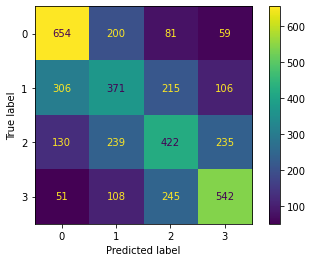

In [107]:
#plot confusion matrix
y_pred_log_cv = cross_val_predict(pipe_log, X_train2, y_train2, cv=5)

log_matrix = confusion_matrix(y_train2, y_pred_log_cv)
ConfusionMatrixDisplay(log_matrix).plot();

### Random Forest

In [106]:
pipe_rf = Pipeline([("vec", TfidfVectorizer()), ("rf", RandomForestClassifier(random_state=42))])

pipe_rf_score = np.mean(cross_val_score(pipe_rf, X_train2, y_train2, cv=5, scoring="accuracy"))

print(f"Random Forest Cross Validation Accuracy Score: {pipe_rf_score*100:,.2f}%")

Random Forest Cross Validation Accuracy Score: 45.56%


In [109]:
#Grid search for hyperparameter tuning the Random Forest

# Define parameter grid for the Random Forest Model
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__min_samples_split': [2, 3, 4],
    'rf__max_depth': [None, 25, 50, 75, 100],
    'rf__class_weight': [None, 'balanced'],   
    'vec__ngram_range': [(1, 1), (1, 2)],
    'vec__min_df': [0.01, 0.1, 0.2],
    'vec__max_df': [0.9, 0.95, 1.0]
}

forest_grid = GridSearchCV(pipe_rf, rf_param_grid, cv=5, verbose=10, scoring='accuracy', n_jobs=-3)
forest_grid.fit(X_train2, y_train2)


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


KeyboardInterrupt: 